# Analysis of VoC data

Look at data provided to SPI-M on the B.1.351 VoC. File not included in the repo, so change path if running independently.


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.optimize as op

In [2]:
df = pd.read_excel(
    '/Volumes/COVID19_Epi_modelling/DstlDailyData/2021-04-14/VOC202012_02_linelist_20210413.xlsx',
    sheet_name=1,
)
df.dropna(subset=['earliest_specimen_date'],inplace=True)

In [3]:
def todays(x):
    return np.array((pd.to_datetime(x.earliest_specimen_date, format='%d/%m/%Y') - pd.Timestamp("2020-10-01")) // pd.Timedelta('1D'))

In [4]:
dfg = df.groupby('exposure_type').apply(todays)

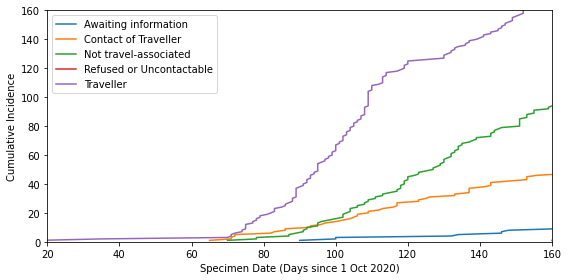

In [5]:
plt.figure(figsize=(8,4))
for i in range(0,len(dfg.index)):
    x = dfg[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=dfg.index[i])
plt.legend()
plt.xlabel('Specimen Date (Days since 1 Oct 2020)')
plt.ylabel('Cumulative Incidence')
plt.ylim([0,160])
plt.xlim([20,160])
plt.tight_layout()
#plt.savefig('./voc_c.pdf')

In [6]:
# Use this to estimate a 'realistic' FOI from a Gamma process
# Also remove the first point to avoid problems

In [7]:
traw = np.sort(x[x>=70])
tmin = np.min(traw)
traw -= tmin

In [8]:
tt, yy = np.unique(traw, return_counts=True)
cc = np.cumsum(yy)
n = len(tt)
tt = tt.astype(np.double)
cc = cc.astype(np.double)

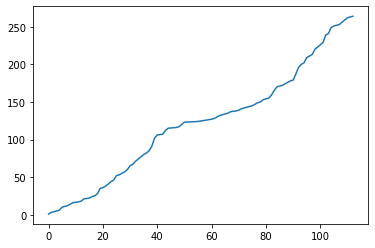

In [9]:
plt.plot(tt,cc)

In [10]:
def nllfun(x,tt,cc,nn):
    t = np.zeros_like(cc)
    y = np.zeros_like(cc)
    al = np.zeros_like(cc)
    bt = np.zeros_like(cc)
    al[0] = x[0]
    bt[0] = x[1]
    ga = x[2]
    nll=0
    for i in range(1,nn):
        y[i] = cc[i] - cc[i-1]
        t[i] = tt[i] - tt[i-1]
        al[i] = np.exp(-ga*t[i])*al[i-1]
        bt[i] = np.exp(-ga*t[i])*bt[i-1]
        nll -= y[i]*np.log(t[i]/(t[i]+bt[i])) + al[i]*np.log((bt[i]/(t[i]+bt[i])))
        nll -= sp.gammaln(al[i]+y[i]) - sp.gammaln(1+y[i]) - sp.gammaln(al[i])
        al[i] += y[i]
        bt[i] += t[i]
    return nll

In [11]:
#Optimizer to fit the initial conditions
nll = lambda xx: nllfun(np.abs(xx),tt,cc,n)
fout = op.minimize(nll,np.array([1.,1.,0.]),method='Nelder-Mead')
astar = np.abs(fout.x[0])
bstar = np.abs(fout.x[1])
fout

 final_simplex: (array([[-3.82803355e+03, -2.32326876e+03,  3.52151507e-01],
       [-3.82803346e+03, -2.32326871e+03,  3.52151507e-01],
       [-3.82803345e+03, -2.32326871e+03,  3.52151506e-01],
       [-3.82803354e+03, -2.32326876e+03,  3.52151507e-01]]), array([195.91012591, 195.91012591, 195.91012591, 195.91012591]))
           fun: 195.9101259100692
       message: 'Optimization terminated successfully.'
          nfev: 383
           nit: 200
        status: 0
       success: True
             x: array([-3.82803355e+03, -2.32326876e+03,  3.52151507e-01])

In [12]:
t = np.zeros_like(cc)
y = np.zeros_like(cc)
al = np.zeros_like(cc)
bt = np.zeros_like(cc)
lam = np.zeros_like(cc)
lal = np.zeros_like(cc)
lau = np.zeros_like(cc)
al[0] = astar
bt[0] = bstar

In [13]:
t = np.zeros_like(cc)
y = np.zeros_like(cc)
al = np.zeros_like(cc)
bt = np.zeros_like(cc)
lam = np.zeros_like(cc)
lal = np.zeros_like(cc)
lau = np.zeros_like(cc)
al[0] = astar
bt[0] = bstar
lam[0] = st.gamma.mean(al[0],0,1/bt[0])
lal[0] = st.gamma.ppf(0.025,al[0],0,1/bt[0])
lau[0] = st.gamma.ppf(0.975,al[0],0,1/bt[0])
for i in range(1,n):
    y[i] = cc[i] - cc[i-1]
    t[i] = tt[i] - tt[i-1]
    al[i] = al[i-1]
    bt[i] = bt[i-1]
    al[i] += y[i]
    bt[i] += t[i]
    lam[i] = st.gamma.mean(al[i],0,1/bt[i])
    lal[i] = st.gamma.ppf(0.025,al[i],0,1/bt[i])
    lau[i] = st.gamma.ppf(0.975,al[i],0,1/bt[i])

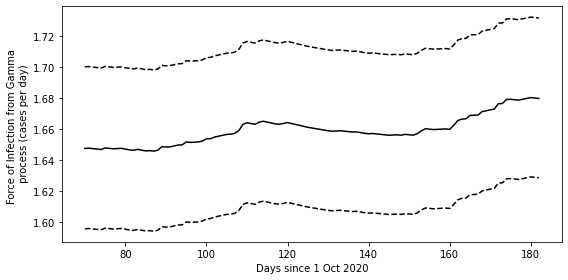

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(tt+tmin,lam,c=[0, 0, 0])
plt.plot(tt+tmin,lal,c=[0, 0, 0],linestyle='dashed')
plt.plot(tt+tmin,lau,c=[0, 0, 0],linestyle='dashed')
plt.xlabel('Days since 1 Oct 2020')
plt.ylabel('Force of Infection from Gamma \n process (cases per day)')
plt.tight_layout()
#plt.savefig('./voc_la.pdf')

In [15]:
am = al
bm = bt
dt = np.gradient(tt)
dth = (np.gradient(bm)/(-1.0*bm**2))/dt
da = (np.gradient(am))/dt
rm = (dth*bm) + (sp.polygamma(1,am)*da)
rv = (sp.polygamma(2,am)*da)
rs = np.sqrt(-rv)

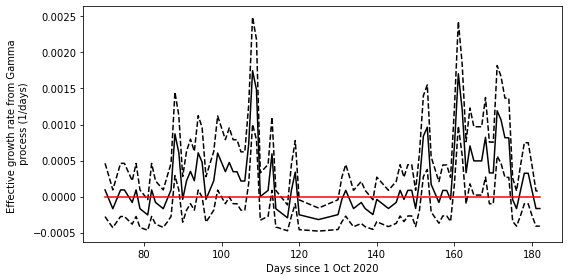

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(tt+tmin,rm,c=[0,0,0])
plt.plot(tt+tmin,rm-rs,c=[0,0,0],linestyle='dashed')
plt.plot(tt+tmin,rm+rs,c=[0,0,0],linestyle='dashed')
plt.plot(tt+tmin,0*tt,c=[1,0,0])
plt.xlabel('Days since 1 Oct 2020')
plt.ylabel('Effective growth rate from Gamma \n process (1/days)')
plt.tight_layout()
#plt.savefig('./voc_r.pdf')

(array([353.,  44.,  10.,   5.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

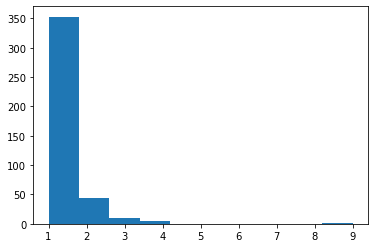

In [17]:
hh = df.groupby('hh_id').apply(len)
plt.hist(hh)

In [18]:
np.max(hh)

9

In [19]:
# Compare to Poisson?

In [20]:
dfr = df.groupby('PHEC_name').apply(todays)

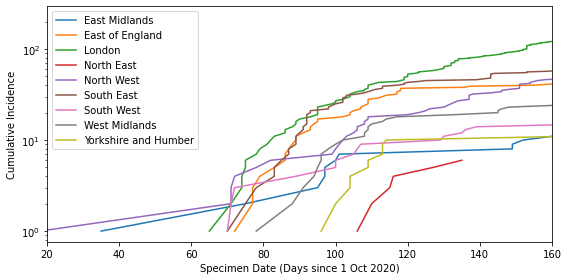

In [21]:
plt.figure(figsize=(8,4))
for i in range(0,len(dfr.index)):
    x = dfr[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=dfr.index[i])
plt.legend()
plt.xlabel('Specimen Date (Days since 1 Oct 2020)')
plt.ylabel('Cumulative Incidence')
plt.xlim([20,160])
plt.yscale('log')
plt.tight_layout()
plt.savefig('./voc_region_log.pdf')

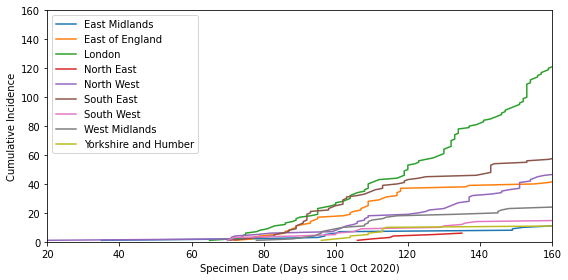

In [22]:
plt.figure(figsize=(8,4))
for i in range(0,len(dfr.index)):
    x = dfr[i]
    plt.plot(np.sort(x),np.arange(1,len(x)+1),label=dfr.index[i])
plt.legend()
plt.xlabel('Specimen Date (Days since 1 Oct 2020)')
plt.ylabel('Cumulative Incidence')
plt.ylim([0,160])
plt.xlim([20,160])
plt.tight_layout()
plt.savefig('./voc_region_lin.pdf')